In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
def preprocess(df):
    listIntToBool = ['AU7', 'AU20', 'looking_away']
    for col in listIntToBool:
        df[col] = df[col].astype('bool')
        
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Timestamp']
    
    listAUDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff','AU12_diff',
                'AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff','AU43_diff']
    listEmoDiff = ['disgust_diff','fear_diff','happiness_diff', 'anger_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    
    listEyes = ['eyeWidth', 'eyeHeight', 'mean_EAR', 'mean_pupil_ratio']
    
    listAU = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11',
              'AU12','AU14','AU15','AU17','AU20','AU23','AU24','AU25','AU26','AU28','AU43']
    
    listFaceDirection = ['Pitch', 'Yaw', 'Roll']
    
    listTest = ['disgust']
    
    ##      + listEmoDiff 
    totalcolumns = listBB + listLandmarks + listTime  + listEyes + listAU + listFaceDirection + listTest
        
    df = df.drop(columns = totalcolumns)
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    df = df.drop(columns=['pupil_direction', 'Person'])
    
    return df

def create_chunks(df, chunk_size):
    columnlist = ['EAR']
    df_new = pd.DataFrame()
    current_chunk = []
    start_of_probe = -1

    for _, row in df.iterrows():
        if start_of_probe < 0 or (row['Frame'] - start_of_probe) >= 500:
            # Finalize the current chunk, if there is one
            if current_chunk:
                chunk_df = pd.DataFrame(current_chunk)
                chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
                for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
                    chunk_summary.update({
                        f'{col}_Q1': chunk_df[col].quantile(0.25),
                        f'{col}_Q2': chunk_df[col].median(),
                        f'{col}_Q3': chunk_df[col].quantile(0.75),
                        f'{col}_SD': chunk_df[col].std(),
                    })
                chunk_summary['Label'] = chunk_df['Label'].values[-1]
                df_new = df_new.append(chunk_summary, ignore_index=True)

            # Start a new probe and a new chunk
            start_of_probe = row['Frame']
            current_chunk = [row]
        elif len(current_chunk) == chunk_size:
            # We have a complete chunk, so finalize it
            chunk_df = pd.DataFrame(current_chunk)
            chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
            for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
                chunk_summary.update({
                    f'{col}_Q1': chunk_df[col].quantile(0.25),
                    f'{col}_Q2': chunk_df[col].median(),
                    f'{col}_Q3': chunk_df[col].quantile(0.75),
                    f'{col}_SD': chunk_df[col].std(),
                })
            chunk_summary['Label'] = chunk_df['Label'].values[-1]
            df_new = df_new.append(chunk_summary, ignore_index=True)
            current_chunk = [row]
        else:
            # Add the current row to the current chunk
            current_chunk.append(row)
            
    # Finalize the last chunk, if there is one
    if current_chunk:
        chunk_df = pd.DataFrame(current_chunk)
        chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
        for col in columnlist:  # calculate quartiles and standard deviation for columns in columnlist
            chunk_summary.update({
                f'{col}_Q1': chunk_df[col].quantile(0.25),
                f'{col}_Q2': chunk_df[col].median(),
                f'{col}_Q3': chunk_df[col].quantile(0.75),
                f'{col}_SD': chunk_df[col].std(),
            })
        chunk_summary['Label'] = chunk_df['Label'].values[-1]
        df_new = df_new.append(chunk_summary, ignore_index=True)

    return df_new

def preprocess_and_chunk(filename, chunk_size):
    df = pd.read_csv(filename)
    mean_value = df['EAR'].iloc[:1000].mean()
    df['calibrated_EAR'] = mean_value
    df['pupil_deviation'] = abs(df['mean_pupil_ratio'] - df['pupil_ratio'])
    df['EAR_deviation'] = abs(df['EAR'] - df['calibrated_EAR'])
    df = preprocess(df)
    df_chunks = create_chunks(df, chunk_size)
    df_chunks = df_chunks.drop(columns='calibrated_EAR')
    return df_chunks

def checkForFullYes(filename):
    df = pd.read_csv(filename)
    counts = df['Label'].value_counts()
    no_count = counts.get('no', 0)
    n_count = counts.get('n', 0)
    finalcount = no_count + n_count
    #print(filename, finalcount)
    return finalcount

In [4]:
# filenames = [f"finaldata/{i}.csv" for i in range(1, 29)]  # ["1.csv", "2.csv", ..., "12.csv"]
# dataframes = []

# chunkBool = True
# chunk_size = 25  

# if chunkBool:
#     for filename in filenames:
#         # finalcount = checkForFullYes(filename)
#         # if finalcount == 0:
#         #     continue
#         chunked_df = preprocess_and_chunk(filename, chunk_size)
#         dataframes.append(chunked_df)
    
# else:
#     for filename in filenames:
#         df = pd.read_csv(filename)
#         preprocessed_df = preprocess(df)
#         dataframes.append(preprocessed_df)

    
# combined_df = pd.concat(dataframes, ignore_index=True)
# X = combined_df.drop(columns=['Label', 'Frame'])
# y = combined_df['Label']

filenames = [f"finaldata_500/{i}.csv" for i in range(1, 39)]  # ["1.csv", "2.csv", ..., "28.csv"]

# Specify which files you want for testing.
test_indices = [5, 11, 23, 17, 8, 32, 37]  # Adjust these numbers based on your needs

train_filenames = [f for i, f in enumerate(filenames, start=1) if i not in test_indices]
test_filenames = [f for i, f in enumerate(filenames, start=1) if i in test_indices]

dataframes_train = []
dataframes_test = []

chunkBool = True
chunk_size = 50  

if chunkBool:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue        
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_train.append(chunked_df)
    
    for filename in test_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue          
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_test.append(chunked_df)
else:
    for filename in train_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_train.append(preprocessed_df)

    for filename in test_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_test.append(preprocessed_df)
    

train_combined_df = pd.concat(dataframes_train, ignore_index=True)
X_train = train_combined_df.drop(columns=['Label', 'Frame'])
y_train = train_combined_df['Label']

test_combined_df = pd.concat(dataframes_test, ignore_index=True)
X_test = test_combined_df.drop(columns=['Label', 'Frame'])
y_test = test_combined_df['Label']


In [5]:
y_test.value_counts()


# 1.00    1516
# 0.00     240

1.0    928
0.0    169
Name: Label, dtype: int64

In [6]:
smote = SMOTE(random_state=42)


In [7]:
print(len(y_train))
print(y_train.value_counts())
## 5270, 1288

3957
1.0    3208
0.0     749
Name: Label, dtype: int64


In [8]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [9]:
# from imblearn.under_sampling import NearMiss

# smoteBool = 0
# undersampleBool = 0

# if smoteBool:
#     print('SMOTE xgboost')
#     X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
#     scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
#     model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
#     model.fit(X_train_smote, y_train_smote)
# elif undersampleBool:
#     print('UNDERSAMPLE xgboost')
#     nm = NearMiss()
#     X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
#     scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
#     model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
#     model.fit(X_train_filled, y_train)
# else:
#     scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
#     print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
#     model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
#                               learning_rate=0.12, min_child_weight=1, max_delta_step=5,
#                               n_estimators = 200)  # Adjust hyperparameters as needed
#     model.fit(X_train_filled, y_train)

from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

smoteBool = 0
undersampleBool = 0

rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=StratifiedKFold(5), scoring='f1_weighted')

if smoteBool:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_smote, y_train_smote)
elif undersampleBool:
    print('UNDERSAMPLE xgboost')
    nm = NearMiss()
    X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200))  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)


REGULAR xgboost, scale_weight:0.2334788029925187


KeyboardInterrupt: 

In [9]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
scaler = StandardScaler()
# Create a pipeline: standardize, then run SVM
svm_clf = make_pipeline(scaler, svm.SVC(class_weight='balanced', random_state=42, probability=1))

# Fit the SVM model
if smoteBool:
    svm_clf.fit(X_train_smote, y_train_smote)
    y_pred_svm = svm_clf.predict(X_test_filled)
else:
    pass
    svm_clf.fit(X_train_filled, y_train)
    y_pred_svm = svm_clf.predict(X_test_filled)


In [10]:
print(len(X_train_filled))

y_pred = model.predict(X_test_filled)
print('--------- XGB ------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print('------------SVM-------------')
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)


print('------------XGB-PROBA--------------')
y_pred_proba = model.predict_proba(X_test_filled)[:,1]

auroc = roc_auc_score(y_test, y_pred_proba)

print("AUROC: %.2f" % auroc)

## best = 0.27 f1 met svm
## auroc = 0.68


## 21 15
## 20-89 and 33-74
## nu 27-90 en 35-73

## Confusion Matrix xgb:
# [[  63  215]
#  [ 129 1571]]
# Confusion Matrix svm:
# [[ 205   73]
#  [ 681 1019]]

3957
--------- XGB ------------
Accuracy: 75.93%
              precision    recall  f1-score   support

         0.0       0.28      0.36      0.32       169
         1.0       0.88      0.83      0.85       928

    accuracy                           0.76      1097
   macro avg       0.58      0.60      0.59      1097
weighted avg       0.79      0.76      0.77      1097

Confusion Matrix:
[[ 61 108]
 [156 772]]
------------SVM-------------
Accuracy: 61.80%
              precision    recall  f1-score   support

         0.0       0.23      0.64      0.34       169
         1.0       0.90      0.61      0.73       928

    accuracy                           0.62      1097
   macro avg       0.57      0.63      0.54      1097
weighted avg       0.80      0.62      0.67      1097

Confusion Matrix:
[[109  60]
 [359 569]]
------------XGB-PROBA--------------
AUROC: 0.65


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


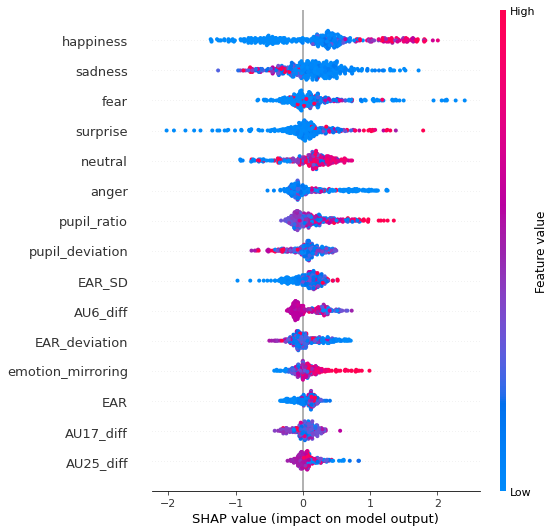

In [11]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Define the number of samples you want
num_samples = 350

# Calculate Shap values
if smoteBool:
    print('smote')
    sample = X_train_smote.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)
else:
    sample = X_train_filled.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, max_display=15)


In [12]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_smote, X_test_filled, y_train_smote, y_test)

# Prints the model performance
print(models)

100%|██████████| 29/29 [00:24<00:00,  1.19it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearSVC                          0.58               0.65     0.65      0.63   
LinearDiscriminantAnalysis         0.58               0.63     0.63      0.64   
SVC                                0.64               0.63     0.63      0.69   
RidgeClassifierCV                  0.58               0.63     0.63      0.63   
LogisticRegression                 0.58               0.63     0.63      0.64   
RidgeClassifier                    0.58               0.63     0.63      0.64   
BernoulliNB                        0.61               0.62     0.62      0.66   
CalibratedClassifierCV             0.55               0.61     0.61      0.61   
AdaBoostClassifier                 0.78               0.61     0.61      0.79   
NearestCentroid                    0.57               0.60     0.60      0.63   
SGDClassifier               

In [13]:
# ###Create a background dataset (you can also use a subset of your train dataset)
# background_data = X_train_filled.iloc[90:93,:]

# ###Use KernelExplainer for SVM
# explainer = shap.KernelExplainer(svm_clf.predict_proba, background_data)

# ###Calculate shap_values for all of X
# shap_values = explainer.shap_values(X_test_filled)

# ###Plot the SHAP values
# shap.summary_plot(shap_values, X_test_filled)


Accuracy: 61.80%
              precision    recall  f1-score   support

         0.0       0.23      0.64      0.34       169
         1.0       0.90      0.61      0.73       928

    accuracy                           0.62      1097
   macro avg       0.57      0.63      0.54      1097
weighted avg       0.80      0.62      0.67      1097



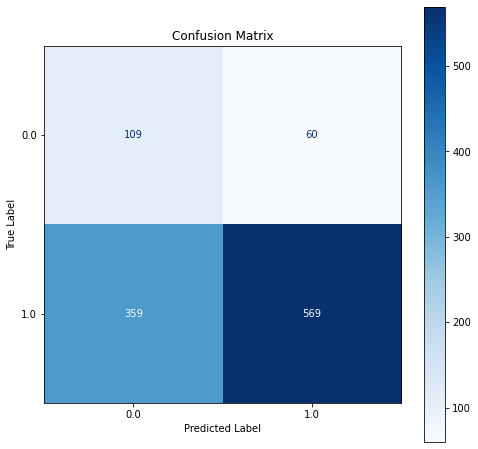

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [15]:
y_test.value_counts()

1.00    928
0.00    169
Name: Label, dtype: int64

In [16]:
y_test.value_counts()

1.00    928
0.00    169
Name: Label, dtype: int64

In [17]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 4],
#     'min_child_weight': [1, 3],
#     'gamma': [0.1, 0.01, 0.05],
#     'subsample': [0.4,0.6],
#     'colsample_bytree': [0.3, 0.8],
# }

# # Create an XGBoost classifier with default parameters
# xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# # Define the scoring metric (F1-score)
# scoring = make_scorer(f1_score)

# grid_search = GridSearchCV(
#     estimator=xgb_classifier,
#     param_grid=param_grid,
#     scoring=scoring,
#     cv=2,  # You can use more folds if needed
#     verbose=2,
#     n_jobs=-1,
# )

# if smoteBool:
#     grid_search.fit(X_train_smote, y_train_smote)
# else:
#     grid_search.fit(X_train_filled, y_train)


# # Get the best parameters and the corresponding best F1-score
# best_params = grid_search.best_params_
# best_f1_score = grid_search.best_score_

# print("Best Parameters: ", best_params)
# print("Best F1-score: ", best_f1_score)

# # Train and evaluate the XGBoost model with the best parameters
# best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
# if smoteBool:
#     best_xgb_model.fit(X_train_smote, y_train_smote)
#     y_pred = best_xgb_model.predict(X_test_filled)
# else:
#     best_xgb_model.fit(X_train_filled, y_train)
#     y_pred = best_xgb_model.predict(X_test_filled)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print(classification_report(y_test, y_pred))